# Step 7C: Prepare reddit data for BERT

## 1. Import required libraries

In [1]:
import pandas as pd
from datetime import datetime as dt
import os
import re
import ast
from get_all_tickers import get_tickers as gt
import dataframe_image as df_img
from pandas import ExcelWriter 

## 2. Repeat steps done in Step 2A
*Since intermediate output was not saved during 2A, the steps are performed again to do some data analysis*

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
path = r"C:\\Users\\Karthik\\Desktop\\Dissertation\\Reddit\\Pickle_Files\\daily_pickle_files\\"
files = os.listdir(path)

comments_df = pd.concat([pd.read_pickle(f'{path}{f}') for f in files], axis=0)
comments_df['top'] = comments_df.apply(lambda x: 'top' if x['link_id'] == x['parent_id'] else 'low', axis=1)
comments_df = comments_df[['id', 'created_utc', 'body', 'top', 'score', 'author']]

comments_df = comments_df.query('top=="top"')
comments_df = comments_df.query('body!="[removed]"')
comments_df = comments_df.query('body!="[deleted]"')

comments_df['year'] = comments_df['created_utc'].apply(lambda x: dt.fromtimestamp(x).strftime('%y'))
comments_df['month'] = comments_df['created_utc'].apply(lambda x: dt.fromtimestamp(x).strftime('%b'))
comments_df['day'] = comments_df['created_utc'].apply(lambda x: dt.fromtimestamp(x).strftime('%d'))

def text_preprocessing(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\!\[gif\]\(.+\)', '', text)
    text = re.sub(r'\(\/message.*\/r\/wallstreetbets\)', '', text)
    text = re.sub(r'[\[\]]', '', text)
    return text

comments_df['original_body'] = comments_df['body']
comments_df['body'] = comments_df.body.apply(lambda x: text_preprocessing(x))
comments_df.reset_index(drop=True, inplace=True)

In [ ]:
ticker_df = pd.read_csv("C:\\Users\\Karthik\\Desktop\\Dissertation\\Tickers\\tickers.csv")
ticker_df

ticker_list = ticker_df['Tickers'].to_list()

comments_df['ticker']=""
#display(comments_df.head())


for index, row in comments_df.iterrows():
    temp_list=[]
    for word in row['body'].split():
        #if word in ticker_list or word.replace('$', '') in ticker_list:
        if re.sub("[$,.'?!&*:;]","",word) in ticker_list:
            temp_list.append(re.sub("[$,.'?!&*:;]","",word))
        
        if len(temp_list) != 0:
            comments_df.at[index, 'ticker'] = list(dict.fromkeys(temp_list))

In [ ]:
comments_df = comments_df[comments_df['ticker'].str.len()==1]

singular_comments_df_list = []

for index, row in comments_df.iterrows():
    for i in row['ticker']:
        singular_comments_df_list.append([row['body'],row['created_utc'],row['id'],row['top'],row['year'],row['month'],row['day'],row['author'],row['score'],i])

refined_df = pd.DataFrame(singular_comments_df_list, columns = ['body','created_utc','id','top','year','month','day','author','score','ticker'])   
refined_df['YearMonDay'] = refined_df['year']  + refined_df['month'] + refined_df['day'].astype(str)

In [ ]:
refined_df.to_csv(r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Reddit\\reddit_refined_data_for_data_analysis.csv', index=False)

## 3. Repeat steps done in 2B
*Since intermediate output was not saved during 2B, the steps are performed again to do some data analysis*

In [ ]:
path = r"C:\\Users\\Karthik\\Desktop\\Dissertation\\Twitter\\tweets\\"
files = os.listdir(path)

comments_df = pd.concat([pd.read_csv(f'{path}{f}') for f in files], axis=0)
comments_df['username'] = comments_df['user'].apply(lambda x: ast.literal_eval(x)['username'])
comments_df = comments_df[['date','content','likeCount','lang','username','id']]
comments_df = comments_df.query('lang=="en"')

def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'&amp;amp', '&', text)
    text = re.sub(r'\&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
comments_df['cleaned_content'] = comments_df.content.apply(lambda x: text_preprocessing(x))

comments_df['year'] = comments_df['date'].apply(lambda x: dt.strptime(x[0:10],'%Y-%m-%d').strftime('%y'))
comments_df['month'] = comments_df['date'].apply(lambda x: dt.strptime(x[0:10],'%Y-%m-%d').strftime('%b'))
comments_df['day'] = comments_df['date'].apply(lambda x: dt.strptime(x[0:10],'%Y-%m-%d').strftime('%d'))

comments_df.reset_index(drop=True, inplace=True)

comments_df['ticker']=""
#display(comments_df.head())


for index, row in comments_df.iterrows():
    temp_list=[]
    for word in row['content'].split():
        #if word in ticker_list or word.replace('$', '') in ticker_list:
        if re.sub("[$,.'?!&*:;]","",word) in ticker_list:
            temp_list.append(re.sub("[$,.'?!&*:;]","",word))
        
        if len(temp_list) != 0:
            comments_df.at[index, 'ticker'] = list(dict.fromkeys(temp_list))
            
singular_comments_df_list = []

for index, row in comments_df.iterrows():
    #for i in row['ticker']:
    if len(row['ticker']) == 1:
        singular_comments_df_list.append([row['date'],row['content'],row['likeCount'],row['lang'],row['cleaned_content'],row['year'],row['month'],row['day'],row['username'],row['id'],row['ticker'][0]])    
        
refined_df = pd.DataFrame(singular_comments_df_list, columns = ['date','content','likeCount','lang','cleaned_content','year','month','day','username','id','ticker'])        
refined_df['YearMonDay'] = refined_df['year'] +refined_df['month'] + refined_df['day'].astype(str)

In [ ]:
refined_df.to_csv(r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Twitter\\twitter_refined_data_for_data_analysis.csv', index=False)

## 3. Data Analysis

### 3.1 *Read the intermediate outputs saved from previous two steps*

In [3]:
refined_reddit_df = pd.read_csv(r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Reddit\\reddit_refined_data_for_data_analysis.csv')
refined_twitter_df = pd.read_csv(r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Twitter\\twitter_refined_data_for_data_analysis.csv')
refined_twitter_df.head()

,date,content,likeCount,lang,cleaned_content,year,month,day,username,id,ticker,YearMonDay
0,2021-09-30 23:54:13+00:00,"I need 1,000 shares of $AAPL",313,en,"I need 1,000 shares of $AAPL",21,Sep,30,LivinRentFree_,1443725905600266245,AAPL,21Sep30
1,2021-09-30 23:54:01+00:00,Apple | $AAPL\n\nApple - Potential Head and Shoulders\n\nLong or short it with BTC on Trade8: https://t.co/7Y3lSIZqdd https://t.co/DJnjORexYx,0,en,Apple | $AAPL Apple - Potential Head and Shoulders Long or short it with BTC on Trade8:,21,Sep,30,IdeasPrime,1443725854081683460,AAPL,21Sep30
2,2021-09-30 23:53:37+00:00,"In iOS 15, Apple's Siri gets even less functional https://t.co/Q1Mlvy21cm $AAPL",0,en,"In iOS 15, Apple's Siri gets even less functional $AAPL",21,Sep,30,MacHashNews,1443725752348786712,AAPL,21Sep30
3,2021-09-30 23:53:35+00:00,iPhone 13 Models Still Include EarPods in the Box in France https://t.co/wKZJwPBOja $AAPL https://t.co/jDObTshZGn,0,en,iPhone 13 Models Still Include EarPods in the Box in France $AAPL,21,Sep,30,MacHashNews,1443725746308988950,AAPL,21Sep30
4,2021-09-30 23:53:33+00:00,Original Apple Watch Added to Apple's 'Vintage Products' List https://t.co/L1sCJXkOy2 $AAPL https://t.co/bxl2U2eq3K,0,en,Original Apple Watch Added to Apple's 'Vintage Products' List $AAPL,21,Sep,30,MacHashNews,1443725735286358040,AAPL,21Sep30


### 3.2 *filter data from reddit and twitter so they have the same dates. This was done prior to predictions as well to keep the conditions for both data equal.*

In [4]:
tick_list = ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']

reddit_list = []
twitter_list = []

for tick in tick_list:

    stock_df = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\{tick}_technical_data_df.pkl")
    df_1 = refined_reddit_df.query(f'ticker == "{tick}"')
    df_2 = refined_twitter_df.query(f'ticker == "{tick}"')

    ymd_reddit = pd.DataFrame(list(df_1['YearMonDay'].unique()), columns=['YearMonDay'])
    ymd_twitter = pd.DataFrame(list(df_2['YearMonDay'].unique()), columns=['YearMonDay'])
    temp_ymd = pd.merge(pd.merge(ymd_reddit, ymd_twitter, how="inner", on="YearMonDay"), pd.DataFrame(stock_df.YearMonDay.unique(), columns=['YearMonDay']), on='YearMonDay')

    df_1 = pd.merge(temp_ymd, df_1, how="inner", on="YearMonDay")
    df_2 = pd.merge(temp_ymd, df_2, how="inner", on="YearMonDay")

    
    reddit_list.append(df_1)
    twitter_list.append(df_2)
    
reddit_df = pd.concat(reddit_list)
twitter_df = pd.concat(twitter_list)

### 3.3 Compute, format and present stats

#### 3.3.1 Compute global statistics (stats for the entire datasets from reddit and twitter)

In [5]:
print('\n\n')
print("Global Statistics:")
print('\n')

#--add a column with date in datetime format which is necessar for computing statistics
tmp_reddit_df = reddit_df.copy(deep=True)
tmp_reddit_df['Datetime'] = tmp_reddit_df['year'].astype('str')+tmp_reddit_df['month']+tmp_reddit_df['day'].astype('str')
tmp_reddit_df['Datetime'] = pd.to_datetime(tmp_reddit_df['Datetime'], format="%y%b%d")
tmp_reddit_df.sort_values(by='Datetime', inplace=True)

tmp_twitter_df = twitter_df.copy(deep=True)
tmp_twitter_df['Datetime'] = tmp_twitter_df['year'].astype('str')+tmp_twitter_df['month']+tmp_twitter_df['day'].astype('str')
tmp_twitter_df['Datetime'] = pd.to_datetime(tmp_twitter_df['Datetime'], format="%y%b%d")
tmp_twitter_df.sort_values(by='Datetime', inplace=True)

#--reddit
df_1 = tmp_reddit_df.query("ticker in ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']").groupby('ticker')['author'].nunique().to_frame()
df_2 = tmp_reddit_df.query("ticker in ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']").groupby('ticker')['id'].nunique().to_frame()
df_3 = tmp_reddit_df.query("ticker in ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']").groupby('ticker')['Datetime'].nunique().to_frame()
df_4 = tmp_reddit_df.query("ticker in ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']").groupby('ticker')['Datetime'].min().to_frame()
df_5 = tmp_reddit_df.query("ticker in ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']").groupby('ticker')['Datetime'].max().to_frame()

temp_stats = df_1.merge(df_2,on='ticker').merge(df_3,on='ticker').rename(columns={'author': 'total_unqiue_authors', 'id':'total_comments', 'Datetime':'number_of_days'})
reddit_global_stats = temp_stats.merge(df_4,on='ticker').merge(df_5,on='ticker').rename(columns={'Datetime_x': 'Min_Date', 'Datetime_y':'Max_Date'})
reddit_global_stats = reddit_global_stats[['Min_Date','Max_Date','total_unqiue_authors','total_comments','number_of_days']]

#--twitter
df_1 = tmp_twitter_df.query("ticker in ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']").groupby('ticker')['username'].nunique().to_frame()
df_2 = tmp_twitter_df.query("ticker in ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']").groupby('ticker')['id'].nunique().to_frame()
df_3 = tmp_twitter_df.query("ticker in ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']").groupby('ticker')['Datetime'].nunique().to_frame()

twitter_global_stats = df_1.merge(df_2,on='ticker').merge(df_3,on='ticker').rename(columns={'username': 'total_unqiue_authors', 'id':'total_comments', 'YearMonDay':'number_of_days'})

global_stats = reddit_global_stats.merge(twitter_global_stats, on='ticker')
columns=[('Both', 'Min_Date'), ('Both', 'Max_Date'), ('Reddit', 'total_unqiue_authors_x'), ('Reddit', 'total_comments_x'), ('Reddit', 'number_of_days_x'),
        ('Twitter', 'total_unqiue_authors_y'), ('Twitter', 'total_comments_y'), ('Twitter', 'number_of_days_y')]
global_stats.columns = pd.MultiIndex.from_tuples(columns)

global_stats_styled = global_stats.style.set_properties(**{ 'color': 'black !important',
                                                        'border': '1px black solid !important'
                                                        }).set_table_styles([{
                                                                              'selector': 'th',
                                                                              'props': [('border', '1px black solid !important')]
                                                                            }]).format({
                                                                                        'A': '{:,.2f}'.format,
                                                                                        'B': '{:,.2%}'.format,
                                                                                        })





#--since we use windowing, the predictions only start from the 6th day of each tickers dataset (since window size=5)
#--it is enough to compute the start and end days of prediction using reddit data alone as both reddit and twitter dates are normalized prior to training and prediction
reddit_grouped_ticks = tmp_reddit_df.query("ticker in ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']").groupby('ticker')['Datetime'].unique().to_frame().reset_index(drop=False)
reddit_grouped_ticks['start_date_of_prediction'] = reddit_grouped_ticks['Datetime'].apply(lambda x: x[6])
reddit_grouped_ticks['end_date_of_prediction'] = reddit_grouped_ticks['Datetime'].apply(lambda x: x[-1])
df_6 = reddit_grouped_ticks[['ticker','start_date_of_prediction','end_date_of_prediction']]


path = 'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Tables\\'
xl_writer = ExcelWriter(f'{path}Global_Stats.xlsx')
global_stats_styled.to_excel(xl_writer, sheet_name='Global Stats')
df_6.to_excel(xl_writer, sheet_name='Prediction Dates')
xl_writer.save() 

df_img.export(global_stats_styled, f'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Global_statistics.png')
global_stats_styled




Global Statistics:




C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\excel.py:331: CSSWarning: Unhandled color format: 'black !important'
  warnings.warn(f"Unhandled color format: {repr(val)}", CSSWarning)


#### 3.3.2 Compute stats for each ticker under redddit and twitter

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = 'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Tables\\'

tick_list = ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']

xl_writer = ExcelWriter(f'{path}Ticker_Level_Stats.xlsx')

for tick in tick_list:
    print('\n\n')
    print(f'Statistics for {tick}:')
    print('\n')
    local_stats = pd.merge(
                        reddit_df.query(f'ticker == "{tick}"').groupby('YearMonDay').agg({'author': pd.Series.nunique, 'id':pd.Series.nunique, 'score': 'sum'}).rename(columns={'author': 'authors_per_day', 'id':'comments_per_day', 'score':'sum_of_scores_per_day'}).describe().applymap(lambda x: f"{x:0.2f}"),
                        twitter_df.query(f'ticker == "{tick}"').groupby('YearMonDay').agg({'username': pd.Series.nunique, 'id':pd.Series.nunique, 'likeCount': 'sum'}).rename(columns={'username': 'authors_per_day', 'id':'comments_per_day', 'likeCount':'sum_of_scores_per_day'}).describe().applymap(lambda x: f"{x:0.2f}"),
                        left_index=True, right_index=True
                        )
    
    columns=[('Reddit', 'authors_per_day_x'), ('Reddit', 'comments_per_day_x'), ('Reddit', 'sum_of_scores_per_day_x'),
            ('Twitter', 'authors_per_day_y'), ('Twitter', 'comments_per_day_y'), ('Twitter', 'sum_of_scores_per_day_y')]
    local_stats.columns = pd.MultiIndex.from_tuples(columns)

    local_stats_styled = local_stats.style.set_properties(**{ 'color': 'black !important',
                                                            'border': '1px black solid !important'
                                                            }).set_table_styles([{
                                                                                  'selector': 'th',
                                                                                  'props': [('border', '1px black solid !important')]
                                                                                }]).format({
                                                                                            'A': '{:,.2f}'.format,
                                                                                            'B': '{:,.2%}'.format,
                                                                                            })
    
    local_stats_styled.to_excel(xl_writer, sheet_name=f'{tick}')
    df_img.export(local_stats_styled, f'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Subplots\\{tick}_stats.png')
    display(local_stats_styled)

xl_writer.save()    




Statistics for AMC:







Statistics for AMD:







Statistics for DKNG:







Statistics for TSLA:







Statistics for BABA:




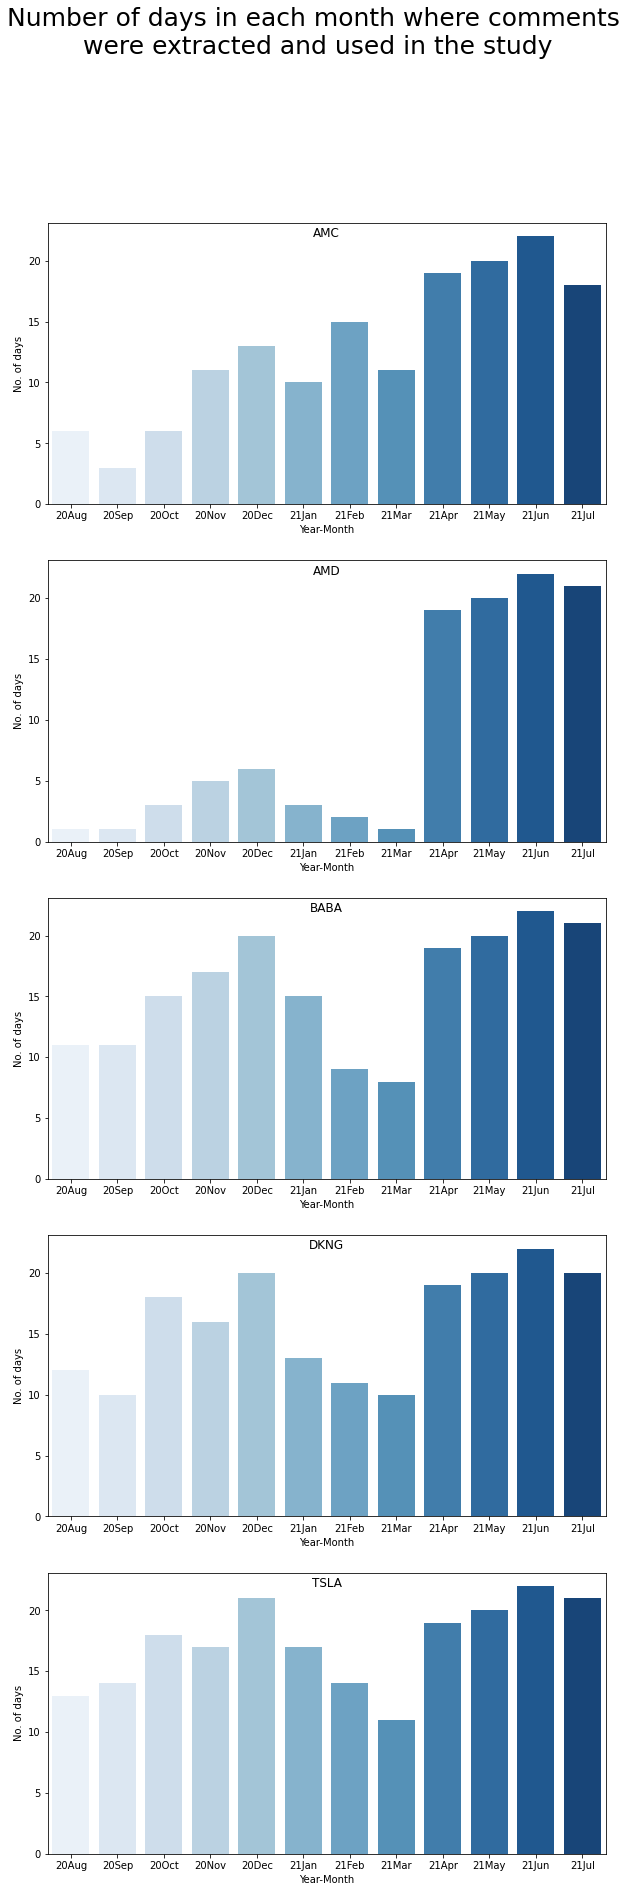

In [7]:
tmp = reddit_df.query(f'ticker == "AMC"').groupby(['ticker','year','month'])['YearMonDay'].nunique().to_frame()

import matplotlib.pyplot as plt
import seaborn as sns

tickers = reddit_df.ticker.unique().tolist()
tickers.sort()

fig = plt.figure(figsize=(10, 30))
fig.suptitle('Number of days in each month where comments \nwere extracted and used in the study', fontsize=25, fontweight=5)

ax = fig.subplots(nrows=len(tickers), ncols=1)
ax_i=0

for tick in tickers:
    #since we normalize the dates between twitter and reddit just one dataset is enough to see on which dates data are available
    tmp_reddit = reddit_df.query(f'ticker == "{tick}"').copy(deep=True)
    tmp_reddit_grouped = tmp_reddit.groupby(['year','month'], as_index=False)['YearMonDay'].nunique()
    
    #create a column with datetime format so that we can sort the data properly according to year and month
    tmp_reddit_grouped['Datetime'] = tmp_reddit_grouped['year'].astype('str')+tmp_reddit_grouped['month']
    tmp_reddit_grouped['Datetime'] = pd.to_datetime(tmp_reddit_grouped['Datetime'], format="%y%b")
    tmp_reddit_grouped = tmp_reddit_grouped.sort_values(by='Datetime')
    tmp_reddit_grouped['Year-Month'] = tmp_reddit_grouped['year'].astype('str') + tmp_reddit_grouped['month']  
    
    sns.barplot(x="Year-Month", y="YearMonDay", data=tmp_reddit_grouped, ax=ax[ax_i], palette='Blues')
    ax[ax_i].set_title(f'{tick}', pad=-14, y=1)
    ax[ax_i].set_ylabel('No. of days')
    ax_i+=1   
    
path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\'
plt.savefig(f'{path}Number of days of data in each month.jpg')
plt.show();

#### 3.3.3 Find top authors for each ticker under reddit and twitter

In [ ]:
tick_list = ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']

reddit_list = []

for tick in tick_list:
    reddit_df_grouped = reddit_df.query(f'ticker == "{tick}"').groupby(['YearMonDay','author'], as_index=False).sum('score')[['YearMonDay', 'author']]
    reddit_dummied = pd.get_dummies(reddit_df_grouped, columns=['author'])
    reddit_dummied = reddit_dummied.loc[:, reddit_dummied.columns != 'YearMonDay']
    tmp_df = pd.DataFrame(reddit_dummied.sum().sort_values(ascending=False, inplace=False)[:5], columns=['count']).reset_index(drop=False).rename(columns={'index':'author'})
    tmp_df['author'] = tmp_df['author'].str.replace('author_','')
    columns=[(f'{tick}', 'author'), (f'{tick}', 'count')]
    tmp_df.columns = pd.MultiIndex.from_tuples(columns)
    reddit_list.append(tmp_df)

    
top_authors = pd.concat(reddit_list, axis=1)   
top_authors_styled = top_authors.style.set_properties(**{ 'color': 'black !important',
                                                        'border': '1px black solid !important'
                                                        }).set_table_styles([{
                                                                              'selector': 'th',
                                                                              'props': [('border', '1px black solid !important')]
                                                                            }]).format({
                                                                                        'A': '{:,.2f}'.format,
                                                                                        'B': '{:,.2%}'.format,
                                                                                        })
   
df_img.export(top_authors_styled, f'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Reddit_top_authors.png')
top_authors_styled

In [ ]:
tick_list = ['AMC', 'AMD', 'DKNG', 'TSLA', 'BABA']

twitter_list = []

for tick in tick_list:
    twitter_df_grouped = twitter_df.query(f'ticker == "{tick}"').groupby(['YearMonDay','username'], as_index=False).sum('score')[['YearMonDay', 'username']]
    twitter_dummied = pd.get_dummies(twitter_df_grouped, columns=['username'])
    twitter_dummied = twitter_dummied.loc[:, twitter_dummied.columns != 'YearMonDay']
    tmp_df = pd.DataFrame(twitter_dummied.sum().sort_values(ascending=False, inplace=False)[:5], columns=['count']).reset_index(drop=False).rename(columns={'index':'author'})
    tmp_df['author'] = tmp_df['author'].str.replace('username_','')
    columns=[(f'{tick}', 'author'), (f'{tick}', 'count')]
    tmp_df.columns = pd.MultiIndex.from_tuples(columns)
    twitter_list.append(tmp_df)

    
top_authors = pd.concat(twitter_list, axis=1)   
top_authors_styled = top_authors.style.set_properties(**{ 'color': 'black !important',
                                                        'border': '1px black solid !important'
                                                        }).set_table_styles([{
                                                                              'selector': 'th',
                                                                              'props': [('border', '1px black solid !important')]
                                                                            }]).format({
                                                                                        'A': '{:,.2f}'.format,
                                                                                        'B': '{:,.2%}'.format,
                                                                                        })
   
df_img.export(top_authors_styled, f'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Twitter_top_authors.png')
top_authors_styled